In [2]:
%matplotlib inline
import random
import os

import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

# trainloader, testloader, model = None, None, None

In [2]:
# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
torch.manual_seed(hash("by removing stochasticity") % 2**32 - 1)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2**32 - 1)

# Device configuration
torch.cuda.set_device(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device", torch.cuda.current_device(), torch.cuda.get_device_name(torch.cuda.current_device()))

device 0 NVIDIA GeForce RTX 3060 Laptop GPU


In [3]:
import wandb

wandb.login()
os.environ["WANDB_API_KEY"] = "a9932db05eeba1bfd135b895b1e586738f267083"

config = dict(
    epochs          = 10,
    batch_size      = 64,
    test_batch_size = 64,
    learning_rate   = 0.001,
    classes         = 10,
    gamma           = 0.5,
    dataset         = "Mnist",
    model           = "CNN",
    activation      = "relu",
    optimizer       = "Adam",
    layer_1         = 6,
    layer_2         = 16,
    layer_3         = 16,
    layer_4         = 16
)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
class_names = ['plane', 'car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ohmygoose0410. Use `wandb login --relogin` to force relogin


In [4]:
import matplotlib.pyplot as plt

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    figure_array = np.transpose(npimg, (1, 2, 0))
    plt.imshow(figure_array)
    # wandb.log({"figure_output": wandb.Image(figure_array, caption="figure")})
    plt.show()


def output_loader_images(loader):
    dataiter = iter(loader)
    images, labels = dataiter.next()

    # show images
    imshow(torchvision.utils.make_grid(images))
    return images, labels

In [5]:
# Conventional and convolutional neural network
class Net(nn.Module):
    def __init__(self, config):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3,  config.layer_1, 5, padding=1)
        self.conv2 = nn.Conv2d(6,  config.layer_2, 3, padding=1) 
        self.conv3 = nn.Conv2d(16, config.layer_3, 3, padding=1)   
        self.conv4 = nn.Conv2d(16, config.layer_4, 5, padding=1)
        self.fc1 = nn.Linear(config.layer_4 * 28 * 28, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, config.classes)
        self.layer_4_output = config.layer_4

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(-1, self.layer_4_output * 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [6]:
import torch.optim as optim

def make(config):
    train_kwargs = {'batch_size': config.batch_size,
                    'num_workers': 2,
                    'pin_memory': True,
                    'shuffle': True}
    test_kwargs  = {'batch_size': config.test_batch_size,
                    'num_workers': 2,
                    'pin_memory': True,
                    'shuffle': True}

    # transform=transforms.Compose([
    #     transforms.ToTensor(),
    #     transforms.Normalize((0.1307,), (0.3081,))
    #     ])

    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, **train_kwargs)
    
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, **test_kwargs)

    _, labels = output_loader_images(trainloader)
    # print labels
    print('labels: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

    # Make the model
    model = Net(config).to(device)

    # Make the loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=config.gamma)
    
    return model, criterion, optimizer, scheduler, trainloader, testloader

In [7]:
def train_log(loss, example_ct, epoch):
    # Where the magic happens
    wandb.log({"epoch": epoch, "loss": loss}, step=example_ct)
    # print(f"Loss after {str(example_ct).zfill(5)} examples: {loss:.3f}")

In [8]:
# save model from the current directory to the mandb directory
import win32api
import ctypes, sys

def is_admin():
    try:
        return ctypes.windll.shell32.IsUserAnAdmin()
    except:
        return False

base_dir = os.path.dirname(os.path.realpath('__file__'))

In [9]:
def test(model, test_loader, criterion):
    model.eval()

    correct, total, test_loss = 0, 0, 0
    with torch.no_grad():
        # images, labels = output_loader_images(test_loader)
        # print('\nGroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

        # outputs = model(images.to(device))
        # _, predicted = torch.max(outputs, 1)
        # print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            test_loss += criterion(outputs, labels).item()
            correct += (predicted == labels).sum().item()

        test_loss /= len(test_loader)
        test_accuracy = 100. * correct / total
        wandb.log({"test_accuracy": test_accuracy, "Average_loss": test_loss})
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, total, test_accuracy))

    # model_name = config["dataset"] + ".onnx"
    # torch.onnx.export(model, images, model_name)

    # if is_admin():
    #     wandb.save(model_name)
    # else:
    #     ctypes.windll.shell32.ShellExecuteW(None, "runas", sys.executable, base_dir, None, 1)
    #     wandb.save(model_name)

In [10]:
def train(model, device, optimizer, criterion, scheduler, config, train_loader, test_loader):
    # Tell wandb to watch what the model gets up to: gradients, weights, and more!
    wandb.watch(model, criterion, log="all", log_freq=10)

    # Run training and track with wandb
    example_ct = 0  # number of examples seen
    batch_ct = 0
    for epoch in range(config.epochs):
        for i, data in enumerate(train_loader, 0):
            
            # get the inputs
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            example_ct +=  len(inputs)
            batch_ct += 1

            # Report metrics every 25th batch
            if ((batch_ct + 1) % 25) == 0:
                train_log(loss, example_ct, epoch)
            # print statistics
            if i == 0:
                print(f"\nEpoch:{epoch+1}")
            print(f"\r\tBatch:{i+1:03} of {len(train_loader)}, loss:{loss.item():.3f}, lr:{scheduler.get_last_lr()[0]:1.10f}", end='')
            
        # and test its final performance
        test(model, test_loader, criterion)
        scheduler.step()

    

## Main

Files already downloaded and verified
Files already downloaded and verified


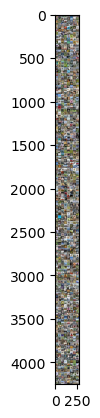

labels:  horse   car horse   car
Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=12544, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Epoch:1
	Batch:050 of 50, loss:1.743, lr:0.0010000000
Test set: Average loss: 1.7006, Accuracy: 3896/10000 (39%)



In [11]:
# tell wandb to get started
run = wandb.init(project="pytorch-demo", config=config, save_code=True)
# access all HPs through wandb.config, so logging matches execution!
config = run.config

# make the model, data, and optimization problem
model, criterion, optimizer, scheduler, trainloader, testloader = make(config)
print(model)

# and use them to train the model
train(model, device, optimizer, criterion, scheduler, config, trainloader, testloader)

In [12]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
preds = np.zeros((1))
truth = np.zeros((1))

# model = torch.load('D:\master_course materials\Deep Learning\code\2022-NYCU-AI-DL\A0\model_all.pt')
# config = run.config
model.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs, 1)
        c = (predicted.cpu() == labels).squeeze()
        preds = np.concatenate([preds, predicted.cpu().numpy()], axis=0)
        truth = np.concatenate([truth, labels.numpy()], axis=0)
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 62 %
Accuracy of   car : 72 %
Accuracy of  bird : 13 %
Accuracy of   cat : 22 %
Accuracy of  deer : 14 %
Accuracy of   dog : 26 %
Accuracy of  frog : 46 %
Accuracy of horse : 36 %
Accuracy of  ship : 25 %
Accuracy of truck : 42 %


Display the confusion matrix as a heatmap

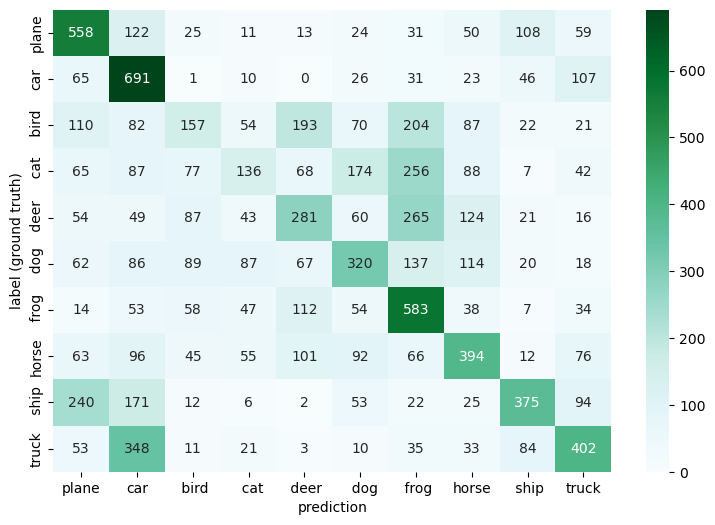

In [13]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
import PIL.Image as Image
import io
# Display the confusion matrix as a heatmap
arr = confusion_matrix(truth, preds)
df_cm = pd.DataFrame(arr, class_names, class_names)
fig = plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")

img_buf = io.BytesIO()
plt.savefig(img_buf, format = "png")
im = Image.open(img_buf)
wandb.log({"figure": wandb.Image(im, caption="heatmap")})
img_buf.close()


Some multi-class performance report defined from Scikit-learn

In [14]:
from sklearn.metrics import classification_report
print(classification_report(truth, preds, target_names=class_names))

              precision    recall  f1-score   support

       plane       0.43      0.56      0.49      1001
         car       0.39      0.69      0.50      1000
        bird       0.28      0.16      0.20      1000
         cat       0.29      0.14      0.19      1000
        deer       0.33      0.28      0.31      1000
         dog       0.36      0.32      0.34      1000
        frog       0.36      0.58      0.44      1000
       horse       0.40      0.39      0.40      1000
        ship       0.53      0.38      0.44      1000
       truck       0.46      0.40      0.43      1000

    accuracy                           0.39     10001
   macro avg       0.38      0.39      0.37     10001
weighted avg       0.38      0.39      0.37     10001



In [15]:
run.finish()

Average_loss,▁
epoch,▁▁
loss,█▁
test_accuracy,▁
Average_loss,1.70063
epoch,0
loss,1.7402
test_accuracy,38.96


wandb.init()
f = open("test.txt", "w")
f.close()
wandb.save('test.txt')
wandb.finish()